# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

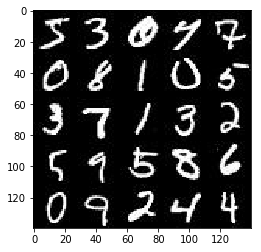

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

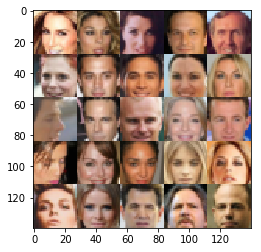

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
            
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescaling the batch image (recommandation of the review)
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, tf.convert_to_tensor(sample_z, dtype=np.float32), data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
import time
start_time = time.time()
time.sleep(2)
execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

00:00:02


Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 2.0263
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.9583


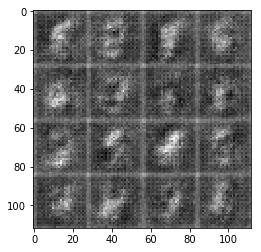

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.4969
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.3788


Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.6678


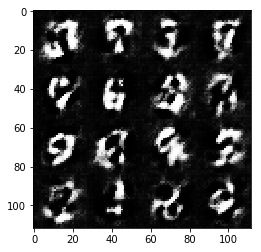

Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.6340
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.6604


Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 0.9663


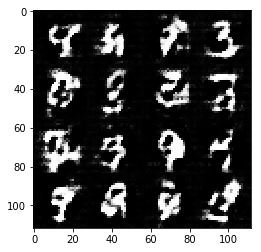

Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.7704
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.8882
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.1285


Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.7380
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.6359


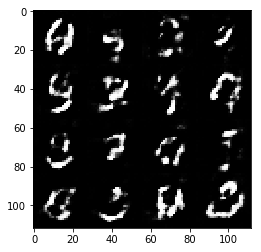

Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.3058
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.6196
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 1.8316
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 1.9639
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.9962
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.7732


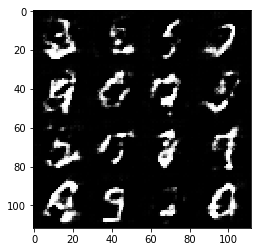

Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.0186
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 1.7200
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 1.8805


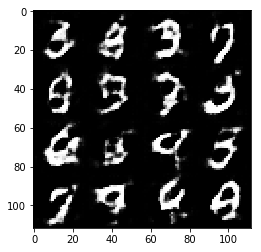

Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 1.9865
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.0843
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.8088


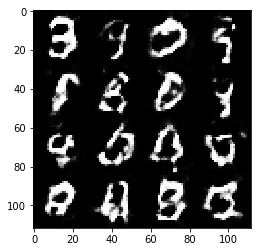

Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 1.7725
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.6999
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.2307


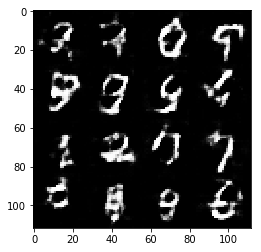

Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.6344
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.2597


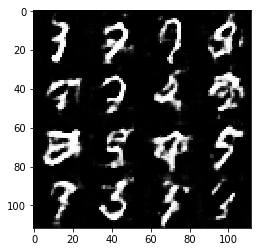

Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 2.2863
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.5320
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.6432
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.6411


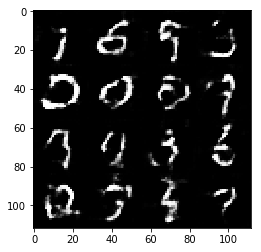

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 1.5852
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.9995
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.3932


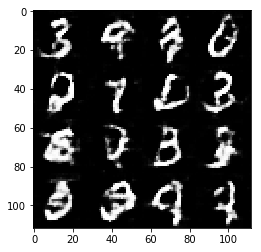

Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 2.4002
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.2853


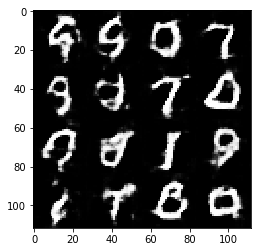

Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.6252
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.7880


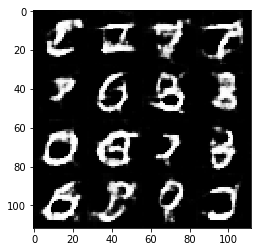

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.7438
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 1.5720
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 1.4324


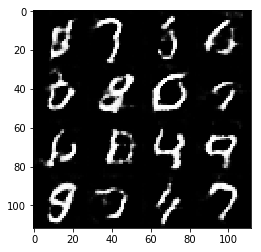

Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.1946


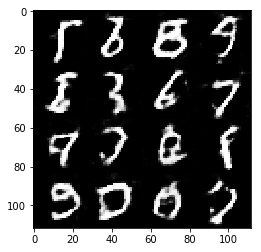

Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.5566
00:01:28


In [13]:
import time

batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

start_time = time.time()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 1.6211
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.2494... Generator Loss: 2.1082
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.2559... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.0235


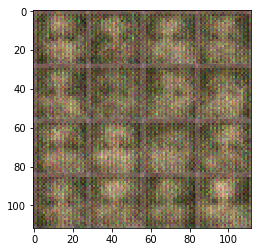

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 2.0880


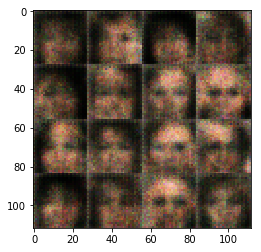

Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 2.4879
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.7672


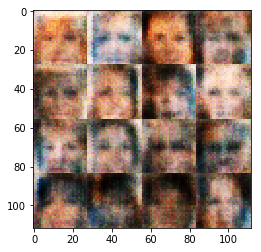

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.3591


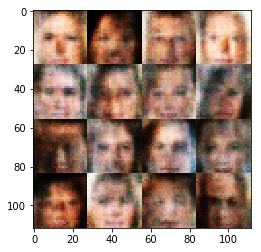

Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9101


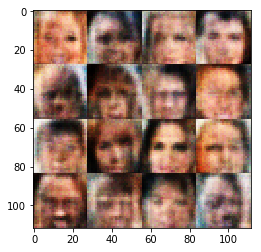

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.8994


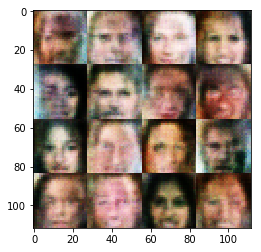

Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.2538


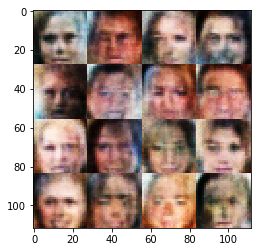

Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0918


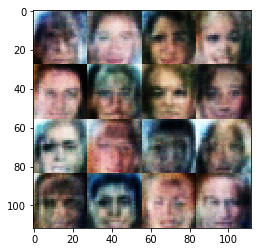

Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.1337


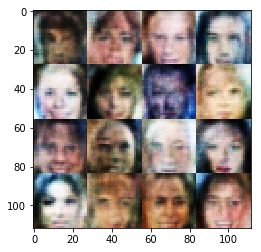

Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 0.9473


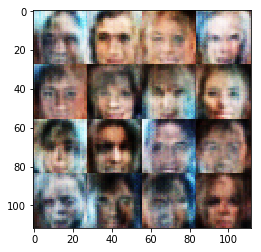

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.7825


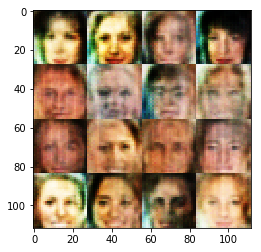

Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.7883


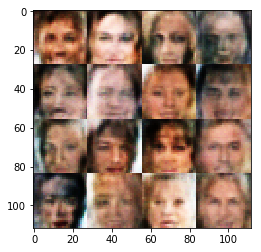

Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0271


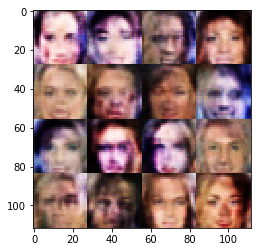

Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0281


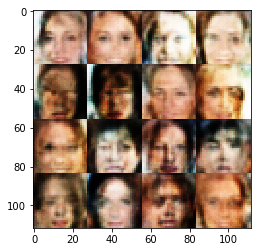

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.0240


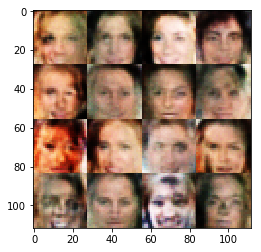

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8338


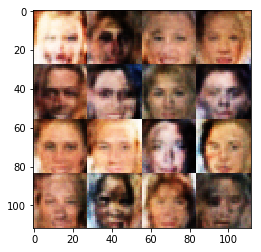

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 0.9080


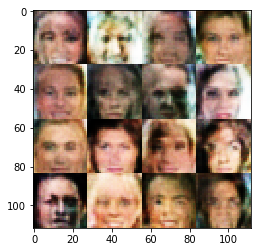

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0459


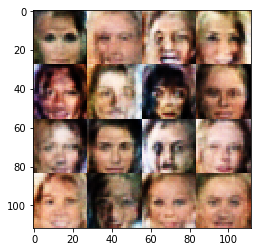

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1749


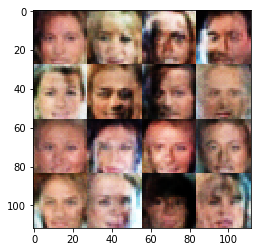

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1801


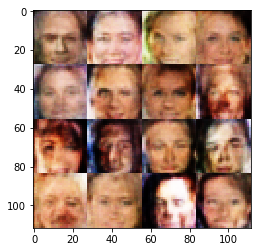

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6027


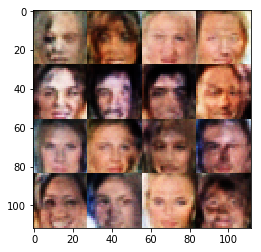

Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.1562


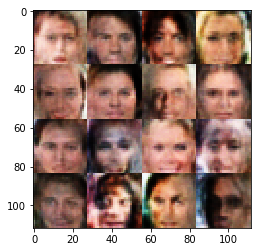

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9923


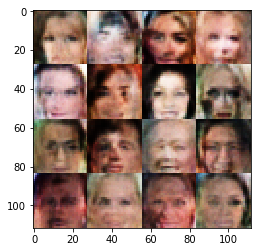

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1601


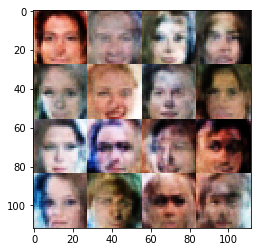

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0048


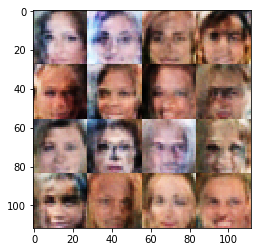

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.7478


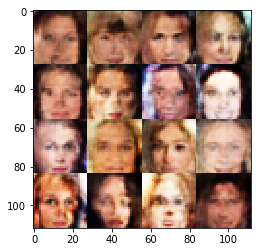

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0255


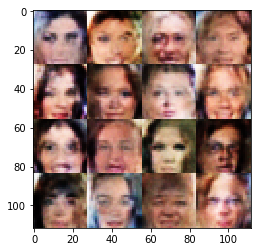

Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.8127


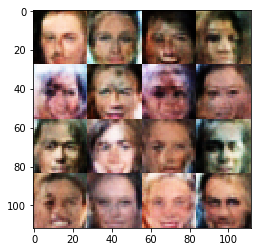

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8184


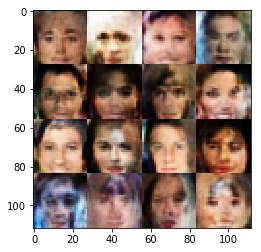

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3631
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0800


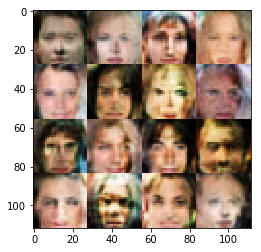

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5903


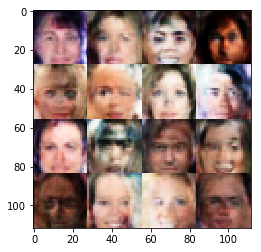

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6859


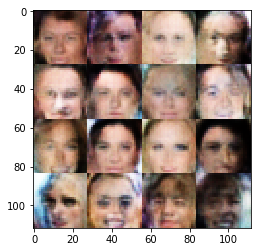

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.1117


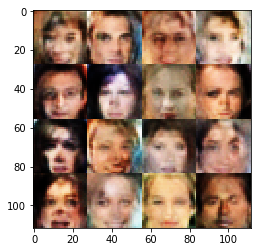

Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0494


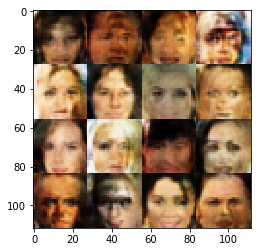

Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0726


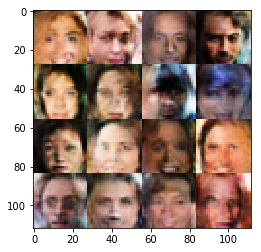

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0476


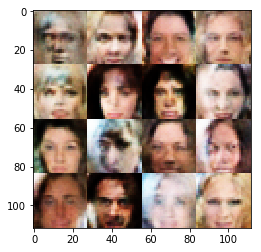

Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7863


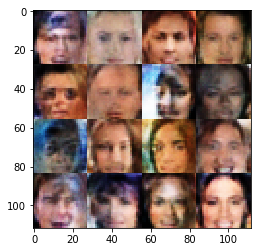

Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8912


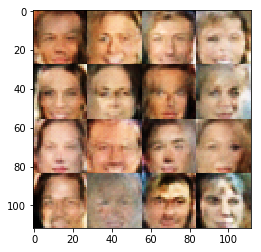

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0825


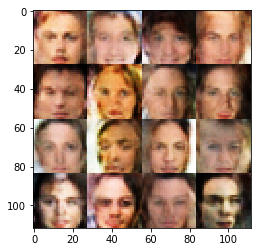

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.3525


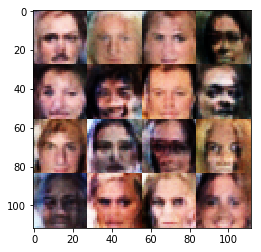

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7357


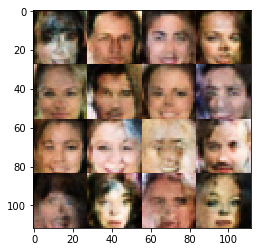

Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.1192


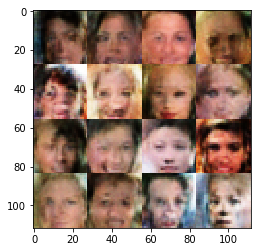

Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5617


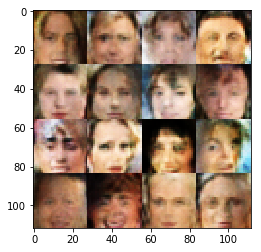

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.7830


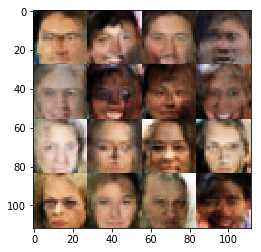

Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7687


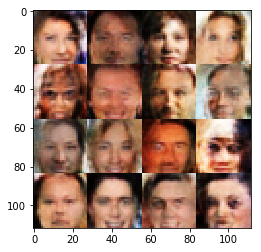

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.7701


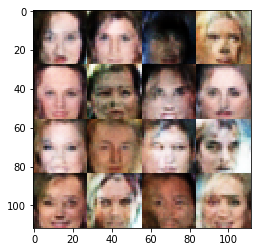

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.2027


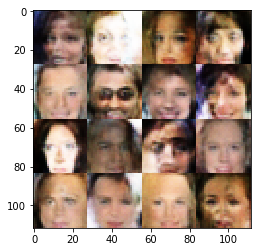

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.1877


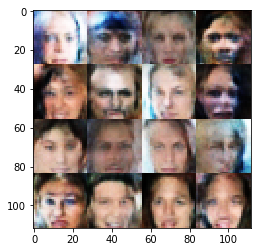

Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7520


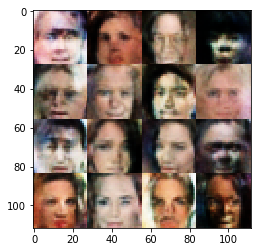

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0239


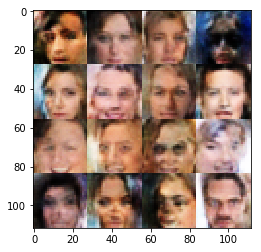

Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9965


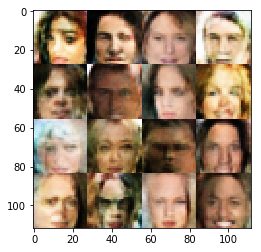

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2843


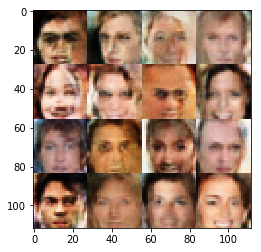

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2171


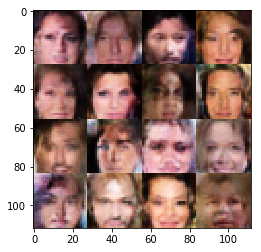

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.9471


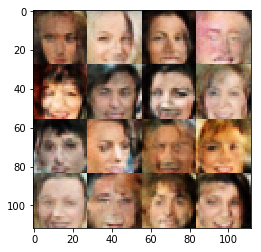

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.8248


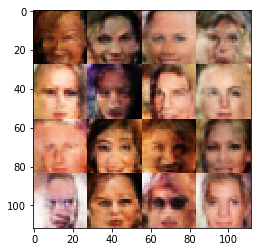

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.4857


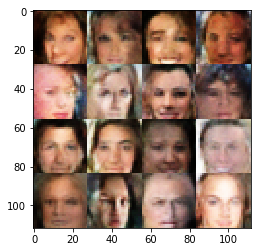

Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.4196


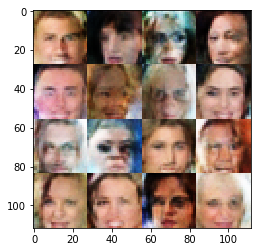

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.4998


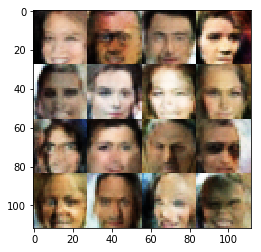

Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0646


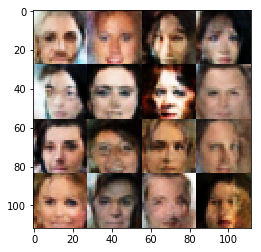

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6865


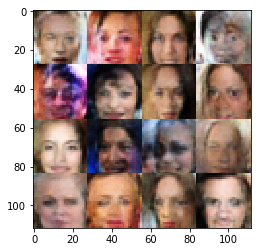

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6965


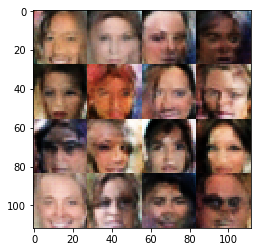

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8053


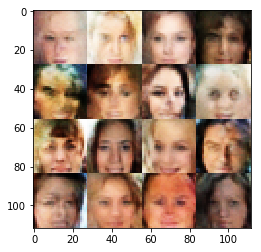

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9479


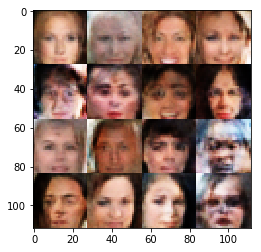

Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.9103
00:13:34


In [24]:
import time


batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 15

start_time = time.time()

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.